In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.stats.multicomp import MultiComparison

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import stats
import scipy 
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [10]:
grid_250 = pd.read_csv('/Users/gimdong-wan/Desktop/DataCampus/data/real_data/250grid_data.csv')

In [11]:
grid_250 = grid_250.fillna(0)

In [12]:
grid_250['성폭력취약인구'] = grid_250['고등여성인구']+grid_250['20대여성인구']
grid_250['건축물(30_)'] = grid_250['건축물(30_34)']+grid_250['건축물(35)']
grid_250['GRADE_폭력'] = grid_250['GRADE_폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_절도'] = grid_250['GRADE_절도'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_성폭력'] = grid_250['GRADE_성폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250 = grid_250.drop(columns = ['20대여성인구','고등여성인구','INDEX'])

In [13]:
new_grid = grid_250[grid_250['GRADE_성폭력']>0]

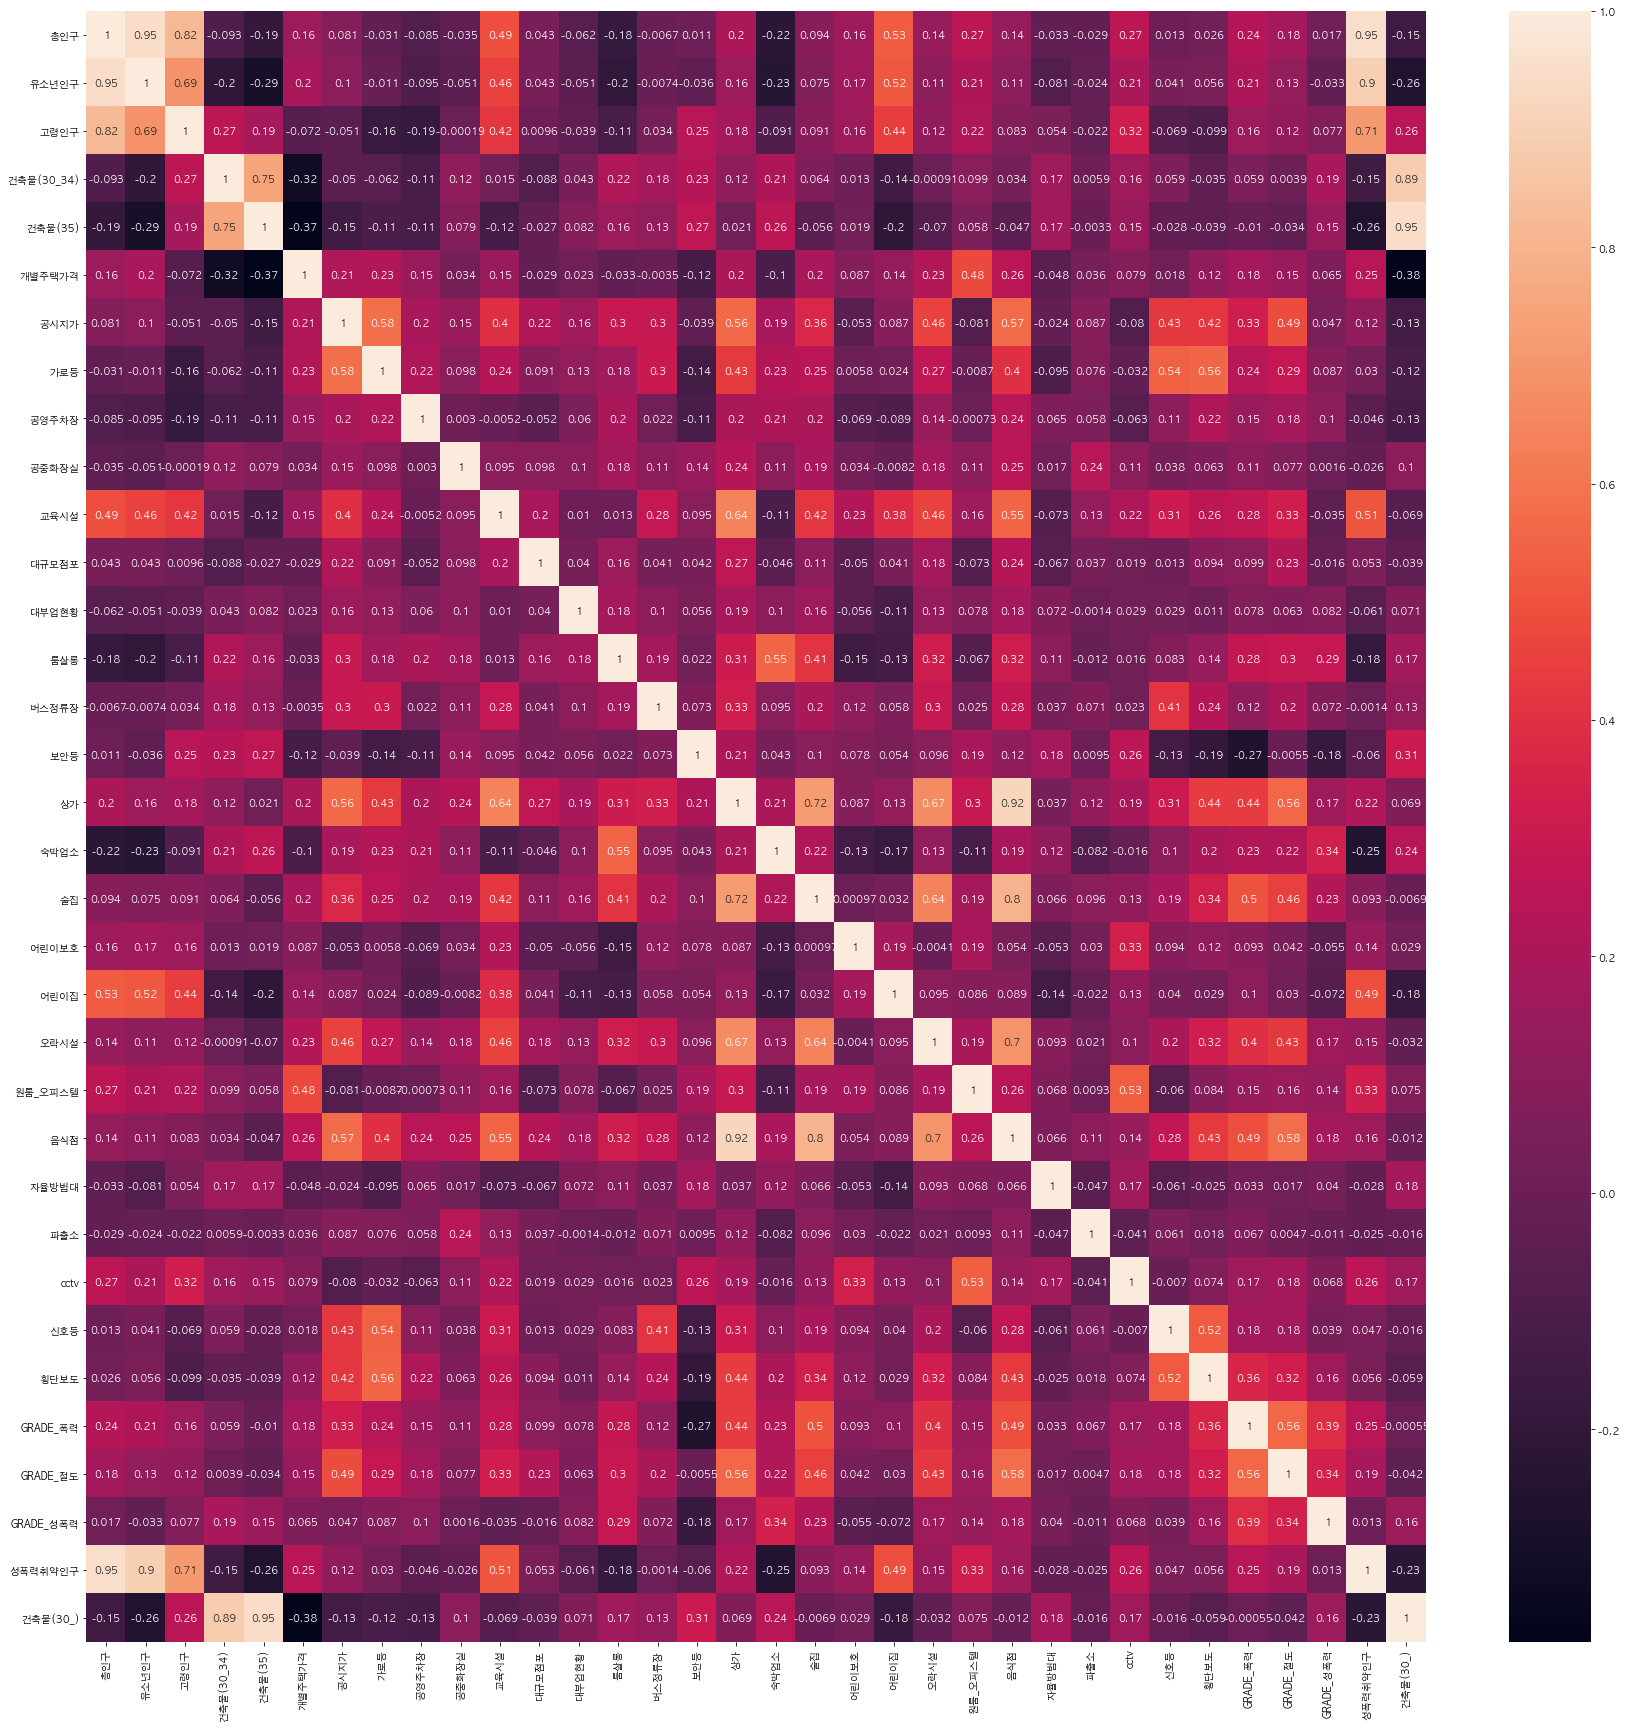

In [17]:
plt.figure(figsize=(30, 30))
sns.heatmap(new_grid.corr(method = 'spearman'), annot=True)
plt.show()

### 행정동별로 평균 범죄주의구간 등급 확인

In [8]:
feat_N = grid_250[(grid_250['총인구']==0)&(grid_250['건축물(30_34)']==0)&(grid_250['건축물(35)']==0)&(grid_250['가로등']==0)&(grid_250['공영주차장']==0)&(grid_250['공중화장실']==0)&(grid_250['숙박업소']==0)
        &(grid_250['대규모점포']==0)&(grid_250['대부업현황']==0)&(grid_250['상가']==0)&(grid_250['어린이보호']==0)&(grid_250['원룸_오피스텔']==0)&(grid_250['cctv']==0)&(grid_250['신호등']==0)&(grid_250['횡단보도']==0)
        &(grid_250['버스정류장']==0)&(grid_250['개별주택가격']==0)] #target 제외 모든 변수가 0인 row
feat_Y = grid_250[(grid_250['총인구']>0)|(grid_250['건축물(30_34)']>0)|(grid_250['건축물(35)']>0)|(grid_250['가로등']>0)|(grid_250['공영주차장']>0)|(grid_250['공중화장실']>0)|(grid_250['숙박업소']>0)
        |(grid_250['대규모점포']>0)|(grid_250['대부업현황']>0)|(grid_250['상가']>0)|(grid_250['어린이보호']>0)|(grid_250['원룸_오피스텔']>0)|(grid_250['cctv']>0)|(grid_250['신호등']>0)|(grid_250['횡단보도']>0)
        |(grid_250['버스정류장']>0)|(grid_250['개별주택가격']>0)] #target 제외 모든 변수가 0보다 큰 row


- 모든 피쳐가 0인 행이 `1460`개이고, 한 피쳐라도 0보다 큰 행은 `2038`개 (공시지가와 타겟 제외)

- 폭력등급이 0보다 큰 로우는 900개, 절도 등급이 0보다 큰 로우는 836개, 성폭력 등급이 0보다 큰 로우는 303개가 있다. 
- 모든 피쳐가 0임에도 불구하고(1460개의 피쳐), 폭력등급이 있는 로우는 19개, 절도 13개, 성폭력 4개가 있었다.

In [139]:
new_grid = feat_Y

In [157]:
out = open('/Users/Desktop/out_2.txt','w')

In [158]:
print(list(new_grid[new_grid['총인구']==0]['ID']),file = out)

In [170]:
new_grid[new_grid['총인구']==0]['ID'].value_counts

<bound method IndexOpsMixin.value_counts of 24      다마55ab66aa
32      다마55ba64ab
45      다마55bb63ba
65      다마56aa64ab
75      다마56ab62ba
           ...    
3357    다마73aa61ba
3358    다마73aa61bb
3398    다마73ba57ba
3421    다마73bb57ab
3424    다마73bb58aa
Name: ID, Length: 575, dtype: object>

In [141]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [142]:
numerical_feats = new_grid.dtypes[new_grid.dtypes != "object"].index.tolist()
numerical_feats.remove('GRADE_폭력')
numerical_feats.remove('GRADE_절도')
numerical_feats.remove('GRADE_성폭력')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = new_grid.dtypes[new_grid.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  31
Number of Categorical features:  2


In [143]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력']).columns)
feature = new_grid[feature_list]
target = new_grid[['GRADE_폭력']]

In [144]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [145]:
new_grid['폭력빈도_4'] = 0

In [146]:
new_grid.loc[(new_grid['GRADE_폭력']==0),'폭력빈도_4'] = 0
new_grid.loc[(new_grid['GRADE_폭력']>0)&(new_grid['GRADE_폭력']<4),'폭력빈도_4'] = 1
new_grid.loc[(new_grid['GRADE_폭력']>=4)&(new_grid['GRADE_폭력']<8),'폭력빈도_4'] = 2
new_grid.loc[(new_grid['GRADE_폭력']>=8)&(new_grid['GRADE_폭력']<11),'폭력빈도_4'] = 3

In [147]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_4']).columns)
feature = new_grid[feature_list]
target = new_grid[['폭력빈도_4']]

In [148]:
print(len(new_grid[new_grid['폭력빈도_4']==3]),len(new_grid[new_grid['GRADE_폭력']==8]),len(new_grid[new_grid['GRADE_폭력']==9]),len(new_grid[new_grid['GRADE_폭력']==10]))

14 5 3 6


In [149]:
new_grid['폭력빈도_3'] = 0

In [150]:
#new_grid.loc[(new_grid['GRADE_폭력']==0),'폭력빈도'] = 0
new_grid.loc[(new_grid['GRADE_폭력']>=0)&(new_grid['GRADE_폭력']<4),'폭력빈도_3'] = 0
new_grid.loc[(new_grid['GRADE_폭력']>=4)&(new_grid['GRADE_폭력']<8),'폭력빈도_3'] = 1
new_grid.loc[(new_grid['GRADE_폭력']>=8)&(new_grid['GRADE_폭력']<11),'폭력빈도_3'] = 2

In [151]:
new_grid['폭력빈도_3'].value_counts()

0    1747
1     277
2      14
Name: 폭력빈도_3, dtype: int64

### 범주별 평균차이 분석 (범주3개)

In [88]:
group_1 = new_grid.loc[(new_grid['폭력빈도_4']==0)]
group_2 = new_grid.loc[(new_grid['폭력빈도_4']==1)]
group_3 = new_grid.loc[(new_grid['폭력빈도_4']==2)]
group_4 = new_grid.loc[(new_grid['폭력빈도_4']==3)]

### 변수 선택을 위한 사후검정 실시

In [89]:
def compare(x,y):
    comp = MultiComparison(new_grid[x], new_grid[y])
    result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
    return result[0]

In [90]:
compare('총인구','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-21.4954,0.0,0.0,True
0,2,-28.5448,0.0,0.0,True
0,3,-7.2803,0.0,0.0,True
1,2,-5.1549,0.0,0.0,True
1,3,-0.3322,0.7398,1.0,False
2,3,1.0357,0.3012,1.0,False


In [91]:
compare('유소년인구','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-13.7066,0.0,0.0,True
0,2,-16.1417,0.0,0.0,True
0,3,-3.1915,0.0015,0.0087,True
1,2,-3.2041,0.0014,0.0084,True
1,3,0.0307,0.9755,1.0,False
2,3,0.8681,0.3861,1.0,False


In [92]:
compare('고령인구','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-23.8366,0.0,0.0,True
0,2,-30.8454,0.0,0.0,True
0,3,-11.0645,0.0,0.0,True
1,2,-4.7053,0.0,0.0,True
1,3,0.0229,0.9817,1.0,False
2,3,1.2051,0.2291,1.0,False


In [93]:
compare('성폭력취약인구','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-21.0764,0.0,0.0,True
0,2,-29.1734,0.0,0.0,True
0,3,-8.145,0.0,0.0,True
1,2,-5.1676,0.0,0.0,True
1,3,-0.3169,0.7514,1.0,False
2,3,1.0491,0.295,1.0,False


In [94]:
compare('건축물(30_34)','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-10.9983,0.0,0.0,True
0,2,-16.1438,0.0,0.0,True
0,3,-18.7301,0.0,0.0,True
1,2,-1.7263,0.0846,0.5079,False
1,3,-1.165,0.2445,1.0,False
2,3,-0.7539,0.4515,1.0,False


In [95]:
compare('건축물(35)','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-15.214,0.0,0.0,True
0,2,-18.2396,0.0,0.0,True
0,3,-3.2265,0.0013,0.0077,True
1,2,-3.1332,0.0018,0.0107,True
1,3,1.0314,0.3028,1.0,False
2,3,1.5531,0.1215,0.729,False


In [96]:
compare('건축물(30_)','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-16.8386,0.0,0.0,True
0,2,-20.3755,0.0,0.0,True
0,3,-6.6373,0.0,0.0,True
1,2,-3.2882,0.001,0.0063,True
1,3,0.5262,0.5989,1.0,False
2,3,1.2152,0.2253,1.0,False


In [97]:
compare('개별주택가격','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-8.2214,0.0,0.0,True
0,2,-8.7079,0.0,0.0,True
0,3,-3.9935,0.0001,0.0004,True
1,2,-2.8241,0.0049,0.0291,True
1,3,-3.0174,0.0027,0.0159,True
2,3,-2.2489,0.0253,0.1516,False


In [98]:
compare('공시지가','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-22.8526,0.0,0.0,True
0,2,-28.8677,0.0,0.0,True
0,3,-14.4483,0.0,0.0,True
1,2,-5.9602,0.0,0.0,True
1,3,-4.7123,0.0,0.0,True
2,3,-2.862,0.0045,0.0271,True


In [99]:
compare('공영주차장','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.6129,0.0,0.0,True
0,2,-10.0858,0.0,0.0,True
0,3,-18.9551,0.0,0.0,True
1,2,-3.5194,0.0005,0.0027,True
1,3,-7.1287,0.0,0.0,True
2,3,-4.0722,0.0001,0.0004,True


In [100]:
compare('공중화장실','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-7.8338,0.0,0.0,True
0,2,-10.3924,0.0,0.0,True
0,3,-5.3607,0.0,0.0,True
1,2,-3.4355,0.0006,0.0037,True
1,3,-2.0357,0.0422,0.2533,False
2,3,-0.5961,0.5516,1.0,False


In [101]:
compare('교육시설','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-14.5655,0.0,0.0,True
0,2,-23.0077,0.0,0.0,True
0,3,-14.7795,0.0,0.0,True
1,2,-5.0039,0.0,0.0,True
1,3,-0.2497,0.8029,1.0,False
2,3,0.9925,0.3218,1.0,False


In [102]:
compare('대규모점포','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.2536,0.0,0.0,True
0,2,-8.5086,0.0,0.0,True
0,3,nan,nan,nan,False
1,2,-2.8006,0.0052,0.0313,True
1,3,0.5773,0.564,1.0,False
2,3,0.9334,0.3514,1.0,False


In [103]:
compare('대부업현황','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-7.3646,0.0,0.0,True
0,2,-10.7553,0.0,0.0,True
0,3,-9.3162,0.0,0.0,True
1,2,-2.4802,0.0133,0.0799,False
1,3,-0.7601,0.4475,1.0,False
2,3,-0.0175,0.986,1.0,False


In [104]:
compare('룸살롱','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-4.0627,0.0001,0.0003,True
0,2,-6.8458,0.0,0.0,True
0,3,-26.1108,0.0,0.0,True
1,2,-4.0015,0.0001,0.0004,True
1,3,-17.6631,0.0,0.0,True
2,3,-8.846,0.0,0.0,True


In [105]:
compare('버스정류장','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-14.5883,0.0,0.0,True
0,2,-17.0894,0.0,0.0,True
0,3,-9.7612,0.0,0.0,True
1,2,-2.7488,0.0061,0.0366,True
1,3,-2.3869,0.0173,0.1038,False
2,3,-1.4436,0.1499,0.8997,False


In [106]:
compare('보안등','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-16.8383,0.0,0.0,True
0,2,-8.4622,0.0,0.0,True
0,3,1.0174,0.3092,1.0,False
1,2,4.2322,0.0,0.0002,True
1,3,2.3982,0.0168,0.1007,False
2,3,1.6909,0.0919,0.5516,False


In [107]:
compare('상가','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-22.9139,0.0,0.0,True
0,2,-32.6357,0.0,0.0,True
0,3,-46.9908,0.0,0.0,True
1,2,-9.6108,0.0,0.0,True
1,3,-6.7467,0.0,0.0,True
2,3,-2.3081,0.0217,0.1302,False


In [108]:
compare('숙박업소','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.9392,0.0,0.0,True
0,2,-8.5825,0.0,0.0,True
0,3,-26.2369,0.0,0.0,True
1,2,-3.243,0.0012,0.0074,True
1,3,-13.1678,0.0,0.0,True
2,3,-6.987,0.0,0.0,True


In [109]:
compare('술집','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-12.7032,0.0,0.0,True
0,2,-21.3793,0.0,0.0,True
0,3,-58.7668,0.0,0.0,True
1,2,-10.2258,0.0,0.0,True
1,3,-27.609,0.0,0.0,True
2,3,-11.1536,0.0,0.0,True


In [110]:
compare('어린이보호','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-7.2463,0.0,0.0,True
0,2,-9.2001,0.0,0.0,True
0,3,-2.2556,0.0243,0.1457,False
1,2,-2.351,0.0189,0.1137,False
1,3,-0.2279,0.8198,1.0,False
2,3,0.3609,0.7184,1.0,False


In [111]:
compare('어린이집','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-12.8803,0.0,0.0,True
0,2,-13.6764,0.0,0.0,True
0,3,-4.2268,0.0,0.0002,True
1,2,-1.7052,0.0885,0.531,False
1,3,0.1758,0.8605,1.0,False
2,3,0.5481,0.584,1.0,False


In [112]:
compare('오락시설','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-13.8708,0.0,0.0,True
0,2,-20.8109,0.0,0.0,True
0,3,-38.4328,0.0,0.0,True
1,2,-7.5913,0.0,0.0,True
1,3,-16.9816,0.0,0.0,True
2,3,-8.6757,0.0,0.0,True


In [113]:
compare('원룸_오피스텔','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-14.7493,0.0,0.0,True
0,2,-18.4356,0.0,0.0,True
0,3,-15.2569,0.0,0.0,True
1,2,-4.1242,0.0,0.0002,True
1,3,-0.7243,0.4692,1.0,False
2,3,0.395,0.6932,1.0,False


In [114]:
compare('음식점','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-19.8887,0.0,0.0,True
0,2,-30.96,0.0,0.0,True
0,3,-42.7992,0.0,0.0,True
1,2,-11.0855,0.0,0.0,True
1,3,-13.8447,0.0,0.0,True
2,3,-6.0386,0.0,0.0,True


In [115]:
compare('자율방범대','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.2673,0.0,0.0,True
0,2,-7.0846,0.0,0.0,True
0,3,-3.2074,0.0014,0.0083,True
1,2,-1.6825,0.0928,0.557,False
1,3,-0.6134,0.5398,1.0,False
2,3,-0.0949,0.9244,1.0,False


In [116]:
compare('파출소','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-4.2311,0.0,0.0001,True
0,2,-6.5782,0.0,0.0,True
0,3,nan,nan,nan,False
1,2,-1.957,0.0507,0.304,False
1,3,0.4649,0.6422,1.0,False
2,3,0.7216,0.4711,1.0,False


In [117]:
compare('cctv','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-21.3197,0.0,0.0,True
0,2,-27.8179,0.0,0.0,True
0,3,-7.5439,0.0,0.0,True
1,2,-5.4667,0.0,0.0,True
1,3,-0.3074,0.7586,1.0,False
2,3,1.0785,0.2817,1.0,False


In [118]:
compare('신호등','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-14.247,0.0,0.0,True
0,2,-16.0279,0.0,0.0,True
0,3,-6.2245,0.0,0.0,True
1,2,-2.2523,0.0246,0.1473,False
1,3,-1.4452,0.1489,0.8936,False
2,3,-0.8795,0.3798,1.0,False


In [119]:
compare('횡단보도','폭력빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-19.3272,0.0,0.0,True
0,2,-28.0984,0.0,0.0,True
0,3,-19.2928,0.0,0.0,True
1,2,-6.7824,0.0,0.0,True
1,3,-6.488,0.0,0.0,True
2,3,-4.158,0.0,0.0003,True


### 종속변수 범주를 잘 구분해줄 것이라 판단되는 피쳐 선택 

##### '총인구','건축물(35)','개별주택가격','공시지가','가로등','공영주차장','공중화장실','교육시설','룸살롱','버스정류장','상가','숙박업소','술집','오락시설','원룸_오피스텔','음식점' 'cctv','횡단보도'
#### target = '폭력빈도_4'

In [120]:
scaler = StandardScaler()
new_grid[numerical_feats] = scaler.fit_transform(new_grid[numerical_feats])

In [121]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_4','폭력빈도_3']).columns)
feature = new_grid[feature_list]
target = new_grid[['폭력빈도_4']]

In [122]:
feature_list

['총인구',
 '유소년인구',
 '고령인구',
 '건축물(30_34)',
 '건축물(35)',
 '개별주택가격',
 '공시지가',
 '가로등',
 '공영주차장',
 '공중화장실',
 '교육시설',
 '대규모점포',
 '대부업현황',
 '룸살롱',
 '버스정류장',
 '보안등',
 '상가',
 '숙박업소',
 '술집',
 '어린이보호',
 '어린이집',
 '오락시설',
 '원룸_오피스텔',
 '음식점',
 '자율방범대',
 '파출소',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구',
 '건축물(30_)']

In [123]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.774288518155054


array([[1104,   51,    2,    0],
       [ 215,  322,   53,    0],
       [  25,  111,  140,    1],
       [   0,    1,    1,   12]])

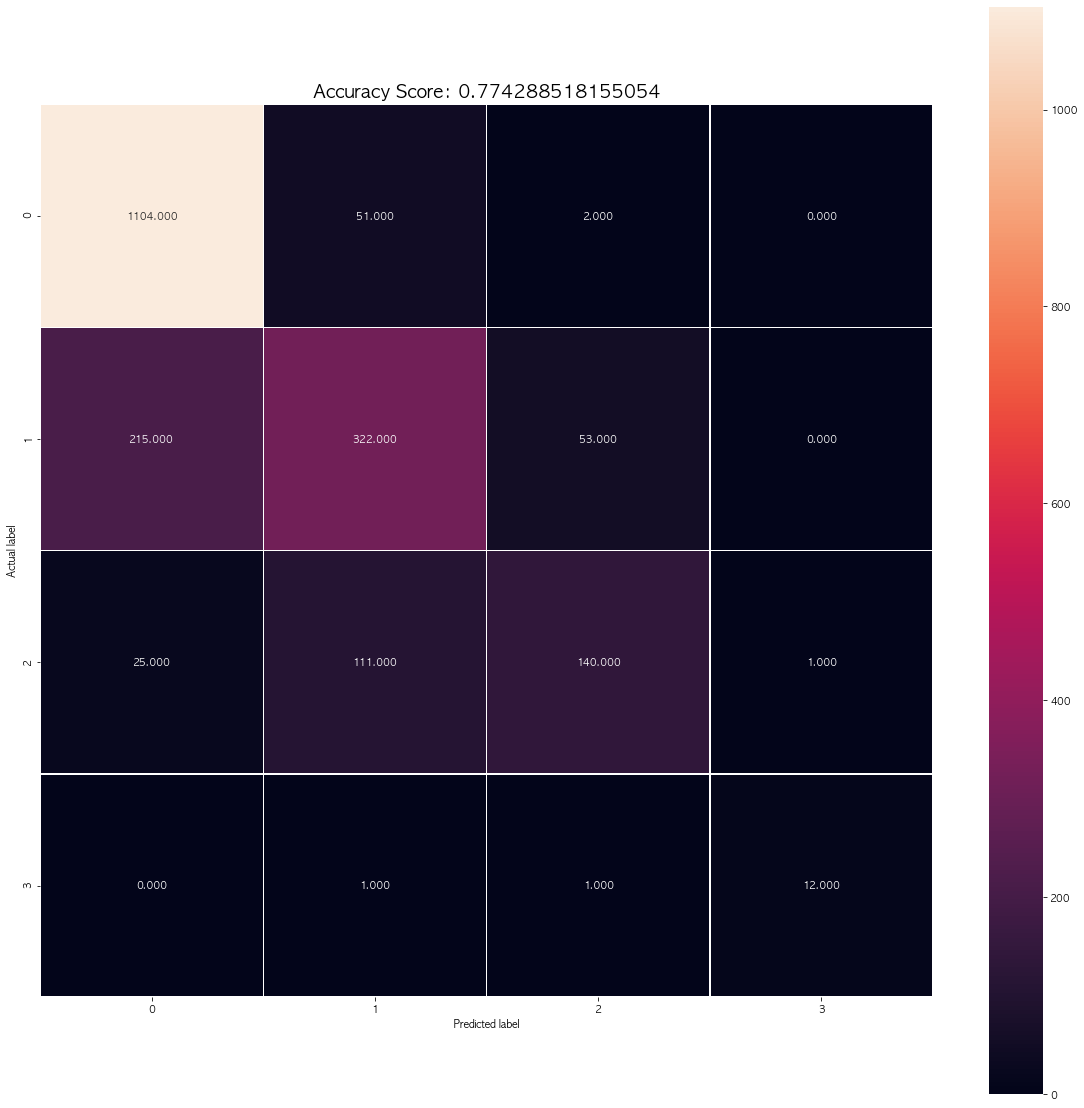

In [124]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

In [323]:
from sklearn.metrics import classification_report
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1157
           1       0.60      0.53      0.56       590
           2       0.61      0.34      0.44       277
           3       0.82      0.64      0.72        14

    accuracy                           0.74      2038
   macro avg       0.71      0.62      0.65      2038
weighted avg       0.72      0.74      0.73      2038



In [324]:
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature = df_train[feature_list]
    target = df_train[['폭력빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['폭력빈도_4'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.75299891, 검증 Accuracy = 0.70588235
학습 Accuracy = 0.74972737, 검증 Accuracy = 0.74019608
학습 Accuracy = 0.75027263, 검증 Accuracy = 0.69117647
학습 Accuracy = 0.73882225, 검증 Accuracy = 0.77450980
학습 Accuracy = 0.75245365, 검증 Accuracy = 0.69117647
학습 Accuracy = 0.73991276, 검증 Accuracy = 0.79901961
학습 Accuracy = 0.74645583, 검증 Accuracy = 0.74019608
학습 Accuracy = 0.74591058, 검증 Accuracy = 0.74019608
학습 Accuracy = 0.74604905, 검증 Accuracy = 0.75369458
학습 Accuracy = 0.75095368, 검증 Accuracy = 0.71921182
[0.70588235 0.74019608 0.69117647 0.7745098  0.69117647 0.79901961
 0.74019608 0.74019608 0.75369458 0.71921182]


0.7355259345117358

## 꽤 높은 정확도를 가짐을 알 수 있음

### Auto ML

In [326]:
from pycaret.classification import *

In [327]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','유소년인구','고령인구','성폭력취약인구','건축물(30_34)',
                                            '건축물(30_)', '대규모점포','대부업현황','보안등','어린이보호','어린이집','자율방범대','파출소','신호등','폭력빈도_3']).columns)
feature = new_grid[feature_list]

In [328]:
# 'voted' 컬럼이 예측 대상이므로 target 인자에 명시
# 'voted' column is the target variable
clf = setup(data = feature,
            train_size = 0.99,
            target = '폭력빈도_4',
            use_gpu = False, 
            session_id = 123,
           fold_shuffle = True)

,Description,Value
0,session_id,123
1,Target,폭력빈도_4
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2, 3: 3"
4,Original Data,"(2038, 19)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [329]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7482,0.8767,0.5353,0.7300,0.7343,0.5406,0.5451,0.3950
catboost,CatBoost Classifier,0.7402,0.8707,0.5204,0.7228,0.7282,0.5286,0.5320,4.9200
gbc,Gradient Boosting Classifier,0.7382,0.8754,0.5369,0.7203,0.7255,0.5247,0.5287,0.8190
et,Extra Trees Classifier,0.7368,0.8708,0.5141,0.7189,0.7235,0.5204,0.5240,0.2960
xgboost,Extreme Gradient Boosting,0.7353,0.8621,0.5806,0.7223,0.7257,0.5223,0.5248,1.6850
lr,Logistic Regression,0.7318,0.8778,0.5412,0.7055,0.7100,0.5011,0.5094,0.6210
lda,Linear Discriminant Analysis,0.7293,0.8611,0.6238,0.7048,0.7069,0.4964,0.5083,0.0190
qda,Quadratic Discriminant Analysis,0.7253,0.8625,0.4506,0.6983,0.7031,0.4874,0.4983,0.0350
lightgbm,Light Gradient Boosting Machine,0.7253,0.8607,0.5450,0.7106,0.7150,0.5044,0.5068,1.6560
nb,Naive Bayes,0.7224,0.8632,0.6181,0.6975,0.6983,0.4820,0.4944,0.0180


In [159]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7599,0.8861,0.5617,0.7448,0.7463,0.5596,0.5649
1,0.7178,0.8593,0.5171,0.6916,0.7001,0.4840,0.4893
2,0.7270,0.8698,0.4608,0.7092,0.7150,0.5030,0.5059
3,0.7866,0.9027,0.7691,0.7836,0.7833,0.6224,0.6233
4,0.7370,0.8638,0.4673,0.7136,0.7219,0.5186,0.5229
Mean,0.7457,0.8764,0.5552,0.7286,0.7333,0.5375,0.5413
SD,0.0248,0.0160,0.1130,0.0324,0.0291,0.0492,0.0481


In [160]:
rf = create_model('rf', cross_validation=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7624,0.8783,0.4687,0.7377,0.7429,0.5583,0.5661
1,0.7772,0.8827,0.7647,0.7684,0.7698,0.5999,0.6029
2,0.7178,0.8546,0.4380,0.6993,0.6987,0.4763,0.4831
3,0.6931,0.8741,0.4118,0.6637,0.6739,0.4380,0.4433
4,0.7277,0.8705,0.5731,0.7073,0.7131,0.5037,0.5082
5,0.7327,0.8649,0.4412,0.7050,0.7101,0.5079,0.5139
6,0.7673,0.9070,0.7544,0.7596,0.7626,0.5875,0.5884
7,0.8159,0.9097,0.5525,0.8117,0.8126,0.6740,0.6748
8,0.7463,0.8368,0.4872,0.7286,0.7342,0.5393,0.5434
9,0.7413,0.8887,0.4610,0.7183,0.7247,0.5213,0.5270


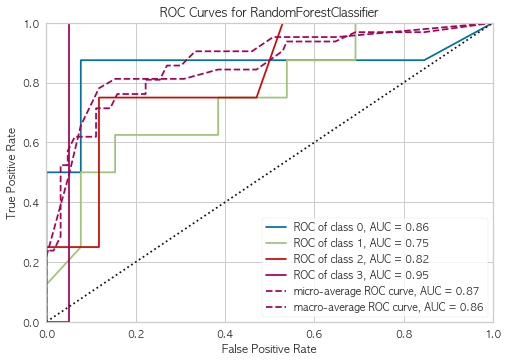

In [161]:
plot_model(rf)

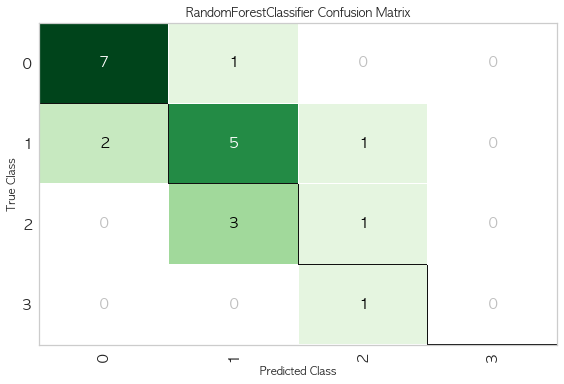

In [162]:
plot_model(rf, plot='confusion_matrix')

In [163]:
evaluate_model(rf)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


In [164]:
plt.rc('font', family="AppleGothic")


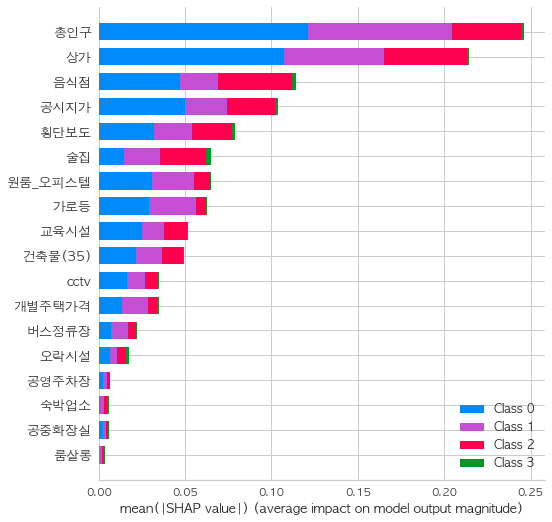

In [165]:
interpret_model(rf)

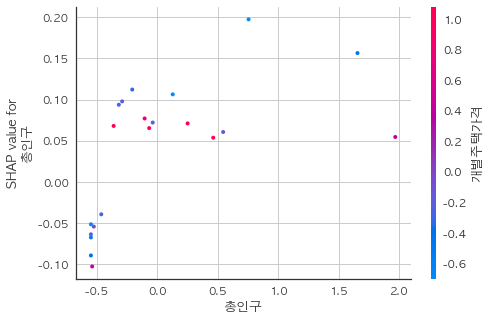

In [166]:
interpret_model(rf, plot='correlation')


In [86]:
#다중공선성확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif["features"] = feature.columns 
vif

,VIF Factor,features
0,1.698339,총인구
1,1.429567,건축물(35)
2,1.165323,개별주택가격
3,2.693413,공시지가
4,1.955871,가로등
5,1.172847,공영주차장
6,1.120778,공중화장실
7,2.003248,교육시설
8,2.046474,룸살롱
9,1.384842,버스정류장
